In [1]:
import tensorflow as tf
from tensorflow.contrib import rnn
# from tensorflow.nn import dynamic_rnn
from tensorflow.python.tools import inspect_checkpoint as chkp # import the inspect_checkpoint library
# import tensorboard as tb
import numpy as np
import scipy.io as sio # for working with .mat files
# import pandas as pd # for working with .xlsx files
from openpyxl import load_workbook # for working with .xlsx files
import matplotlib.pyplot as plt # for plotting the data
from datetime import datetime # for keeping separate TB logs for each run
import os, sys
import textwrap

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


### 1) DATA from prof. A. Procházka:
* **url:**: http://uprt.vscht.cz/prochazka/pedag/Data/dataNN.zip
* **name**: Weekly Elbe river flow
* **Provider source:** Prof. Ing. Aleš Procházka, CSc
* **Span:** 313 weeks ~ 6 years of data
* **Data size:** 313 values
* **Already normalized** to 0 mean and 1 variance

In [2]:
# load data from Q.mat
filename = './datasets/Q.MAT'
data = sio.loadmat(filename) # samples were gathered with period of one week

# convert to np array
data_Elbe = np.array(data['Q'],dtype=np.float32).flatten()

print(np.shape(data_Elbe))

# divide the data into training, testing and validation part
weeks_in_year = 52.1775
years_in_data = 313/weeks_in_year

years_in_train = int(years_in_data*0.7) # 70% of data rounded to the number of years
years_in_test = int(np.ceil(years_in_data*0.15)) # 15% of data rounded to the number of years

weeks_train = int(years_in_train*weeks_in_year) # number of weeks in training data
weeks_test = int(years_in_test*weeks_in_year) # number of weeks in testing data

end_of_train_Elbe = weeks_train
end_of_test_Elbe = weeks_train + weeks_test

(313,)


### 2) DATA from Time Series Data Library:
* **url:** https://datamarket.com/data/set/235a/mean-daily-saugeen-river-flows-jan-01-1915-to-dec-31-1979#!ds=235a&display=line
* **name:** Mean daily Saugeen River (Canada) flows
* **Provider source:** Hipel and McLeod (1994)
* **Span:** Jan 01, 1915 to Dec 31, 1979
* **Data size:** 23741 values

In [8]:
# load excel spreadsheet with openpyxl:
filename = './datasets/sugeen-river-flows.xlsx'
xl = load_workbook(filename)

# print sheet names:
print(xl.get_sheet_names())

# get sheet:
sheet = xl.get_sheet_by_name('Mean daily saugeen River flows,')

data = []

# fill a list with values from cells:
for cell in sheet['B16:B23756']:
    data.append(cell[0].value)

# convert list to numpy array and reshape to a row vector
data = np.array(data)
data_Saugeen = np.reshape(data,(-1))

# divide the data into training, testing and validation part
days_in_data = np.shape(data_Saugeen)[0]
days_in_year = 365.25
years_in_data = days_in_data/days_in_year

years_in_train = int(years_in_data*0.7) # 70% of data rounded to the number of years
years_in_test = int(np.ceil(years_in_data*0.15)) # 15% of data rounded to the number of years

days_train = int(years_in_train*days_in_year) # number of days in training data
days_test = int(years_in_test*days_in_year) # number of days in testing data

end_of_train_Saugeen = days_train
end_of_test_Saugeen = days_train + days_test

['Mean daily saugeen River flows,']


In [9]:
print(np.shape(data_Saugeen))

(23741,)


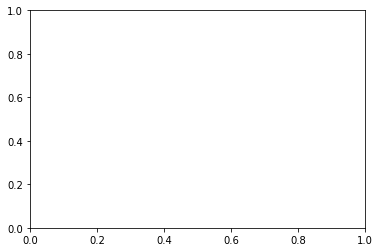

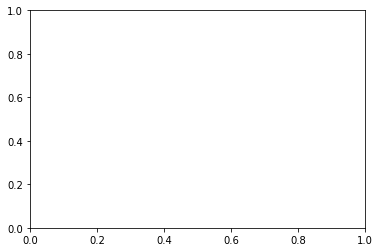

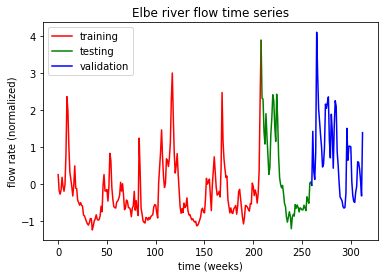

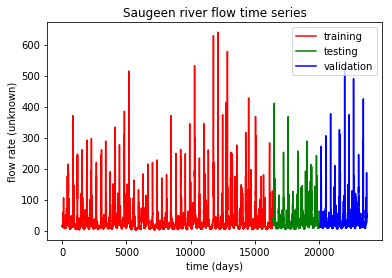

Figures saved to: .\datasets/IMG


In [13]:
# Plot the results
def plot_timeseries(values, end_of_train, end_of_test, selected_data):
    """
    plot the predictions and target values to one figure

    :param values: timeseries values
    :param end_of_train: the end of the training par of the data
    :param end_of_test: the end of the testing part of the data
    :param selected_data: selector of input data (1 == Elbe flow, 2 == Saugeen flow) 
    :return: plot of predictions and target values
    """
    y_train = values[:end_of_train+1]
    y_test = values[end_of_train:end_of_test+1]
    y_validation = values[end_of_test:]
    
    # the x axis values
    x_train = [i for i in range(len(y_train))]
    x_test = [i + end_of_train for i in range(len(y_test))]
    x_validation = [i + end_of_test for i in range(len(y_validation))]
    
    plt.plot(x_train,y_train,color='red',linestyle='solid',linewidth=1.5)
    plt.plot(x_test,y_test,color='green',linestyle='solid',linewidth=1.5)
    plt.plot(x_validation,y_validation,color='blue',linestyle='solid',linewidth=1.5)
    plt.legend(['training', 'testing', 'validation'])
    if selected_data == 1:
        plt.xlabel('time (weeks)')
        plt.ylabel('flow rate (normalized)')
    elif selected_data == 2:
        plt.xlabel('time (days)')
        plt.ylabel('flow rate (unknown)')        
    plt.draw()

f_Elbe = plt.figure()
plot_timeseries(data_Elbe,end_of_train_Elbe,end_of_test_Elbe, selected_data=1)
plt.title('Elbe river flow time series')

f_Saugeen = plt.figure()
plot_timeseries(data_Saugeen,end_of_train_Saugeen,end_of_test_Saugeen, selected_data=2)
plt.title('Saugeen river flow time series')
plt.show()

# Save the figures:
img_save_dir = "datasets/IMG"
save_dir_path = os.path.join(os.curdir, img_save_dir)
os.makedirs(save_dir_path, exist_ok=True)

f_Elbe.savefig(save_dir_path + "/Elbe_dataset.pdf", bbox_inches='tight')
f_Saugeen.savefig(save_dir_path + "/Saugeen_dataset.pdf", bbox_inches='tight')

print("Figures saved to: {}".format(save_dir_path))